In [268]:
import numpy as np
import uproot as ur
import awkward as ak
import sys
sys.path.append('/home/jbohm/start_tf/LCStudies')
from data import particle_data_visualize_plot_utils as pu
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)


Helper functions

In [269]:
def flatten_event_to_cells(event):
    return np.array([cell for clus in event for cell in clus])

def flatten_events_and_clus_to_events(events_data):
    return [[cell_data for clus_data in event_data for cell_data in clus_data] for event_data in events_data]

def flatten_events_to_clus(events_data):
    return [clus_data for event_data in events_data for clus_data in event_data]

def flatten_one_layer(data):
    return [data_layer2 for data_layer1 in data for data_layer2 in data_layer1]

def flatten_layers(data, num_layers=1):
    for i in range(num_layers):
        data = flatten_one_layer(data)
    return data

def flatten_events_to_cells(events_data):
    return [cell_data for clus_data in flatten_events_to_clus(events_data) for cell_data in clus_data]

def DeltaR(etas1, phis1, etas2, phis2):
    return np.sqrt((etas1-etas2)**2 + (phis1-phis2)**2)

In [270]:
def spherical_to_cartesian(rs, phis, thetas):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.cos(phis[i]))
        y.append(r*np.sin(phis[i]))
        z.append( r/np.tan(thetas[i]))

    return np.array(x), np.array(y), np.array(z)

In [271]:
# 3D visualization
def plot_proccessed_cells_in_line(x,y,z,cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx=None, vmin=None, vmax=None, same_axis=True):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(5*len(cell_data), 5)
    for i, cell_data_i in enumerate(cell_data):
        ax = fig.add_subplot(1, len(cell_data), i + 1, projection='3d')
        x_i = x[i] if len(x) > 1 else x[0]
        y_i = y[i] if len(y) > 1 else y[0]
        z_i = z[i] if len(z) > 1 else z[0]
        xlabel_i = xlabel[i] if len(xlabel) > 1 else xlabel[0]
        ylabel_i = ylabel[i] if len(ylabel) > 1 else ylabel[0]
        zlabel_i = zlabel[i] if len(zlabel) > 1 else zlabel[0]
        title_i = title[i] if len(title) > 1 else title[0]

        if bar_label[i] == "Clusters":
            for cluster_idx, clus_x in enumerate(processed_event_data["x"][event_idx]):
                ax.scatter(processed_event_data["z"][event_idx][cluster_idx], clus_x, processed_event_data["y"][event_idx][cluster_idx], label="cluster " + str(cluster_idx + 1))
                ax.legend()
        elif bar_label[i] == "Pi+/- frac class" or bar_label[i] == "Pred EM frac class":
            cut_em_class = np.array(cell_data_i) == 1
            clus_x = np.array(x_i)
            clus_y = np.array(y_i)
            clus_z = np.array(z_i)
            ax.scatter(clus_z[cut_em_class], clus_x[cut_em_class], clus_y[cut_em_class], color="fuchsia")
            ax.scatter(clus_z[~cut_em_class], clus_x[~cut_em_class], clus_y[~cut_em_class], color="cyan")  
        else:
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i])
            #if bar_label[i] != "EM frac class":
            fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)

        ax.set_xlabel(xlabel_i)
        ax.set_ylabel(ylabel_i)
        ax.set_zlabel(zlabel_i)
        plt.title(title_i)
    plt.show()


# plot 3d event info
def plot_event_3d_info(event_idx, pipm_frac, empty_contr_frac, pipm_frac_class=None):
    print("event index:", event_idx)
    print("pipm_frac:", pipm_frac[empty_contr_frac])
    
    file = ur.open("/data/atlas/data/rho_delta/rho_small.root")
    cell_geo_tree = file["CellGeo"]
    cell_geo_data = cell_geo_tree.arrays(library='np')
    cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
    sorter = np.argsort(cell_geo_ID)
    cell_IDs = flatten_one_layer(events_arr['cluster_cell_ID'][event_idx])
    print("num cells:", len(cell_IDs))
    cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

    etas = cell_geo_data["cell_geo_eta"][0][cell_ID_map]
    phis = cell_geo_data["cell_geo_phi"][0][cell_ID_map]
    rPerps = cell_geo_data["cell_geo_rPerp"][0][cell_ID_map]
    samplings = np.array(cell_geo_data["cell_geo_sampling"][0][cell_ID_map])

    thetas = [2*np.arctan(np.exp(-eta)) for eta in etas]
    x, y, z = spherical_to_cartesian(rPerps, phis, thetas)
    
    title = ["Sampling layers", "Cell energy", "Pi+/- frac", "Pi+/- frac class"]
    xlabel = ["z"]
    ylabel = ["x"]
    zlabel = ["y"]

    colour_theme = [plt.cm.tab20b, plt.cm.magma, plt.cm.viridis_r, plt.cm.cool, plt.cm.cool]
    bar_label = ["Sampling layers", "Cell energy (log(GeV))", "Pi+/- frac", "Pi+/- frac class"]
    vmin = [0, None , 0, 0]
    vmax = [23, None, 1, 1]
    cell_data = [samplings[~empty_contr_frac], np.log10(flatten_events_to_clus(events_arr["cluster_cell_E"][event_idx]))[~empty_contr_frac], pipm_frac[~empty_contr_frac]]#, pipm_frac_class]
    
    plot_proccessed_cells_in_line([x[~empty_contr_frac]], [y[~empty_contr_frac]], [z[~empty_contr_frac]], cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx, vmin, vmax)

Load rho event tree

In [407]:
#rho_root_data = ur.open("~/start_tf/rho_full_500.root")
#rho_root_data = ur.open("/data/atlas/data/allCellTruthv1/pipm/user.mswiatlo.27153452.OutputStream._000001.root")
rho_root_data = ur.open("/fast_scratch_1/jbohm/train_testing_data/mltree_100_compare_no_cut.root")
rho_root_data_truth_sum = ur.open("/fast_scratch_1/jbohm/train_testing_data/mltree_100_compare_no_cut_truth_sum.root")

#rho_root_data_summed_truth_E = ur.open("~/start_tf/rho_full_500.root")

events = rho_root_data["EventTree"]
events_truth_sum = rho_root_data_truth_sum["EventTree"]
events_arr = events.arrays(library="ak")
events_arr_truth_sum = events_truth_sum.arrays(library="ak")

#events_arr_truth_E = rho_root_data_summed_truth_E["EventTree"]
#events_arr_summed_truth_E = events_summed_truth_E.arrays(library="ak")

In [149]:
# find unique sets of truth particles
pgIds_pad = []
for event_idx, event_pgIds in enumerate(events_arr["truthPartPdgId"]):
    pgIds_pad.append(np.zeros(8))
    pgIds_pad[event_idx][:len(event_pgIds)] = event_pgIds

unique_truth_particles, num_occurances = np.unique(pgIds_pad, return_counts=True, axis=0)
print(unique_truth_particles)
print(num_occurances)


[[-213. -211.  111.  -11.   11.   22.    0.    0.]
 [-213. -211.  111.  -11.   11.   22.   22.    0.]
 [-213. -211.  111.   22.   22.    0.    0.    0.]
 [-213. -211.  111.   22.   22.   22.    0.    0.]
 [-213. -211.  111.   22.   22.   22.   22.    0.]
 [ 213.  211.  111.  -11.   11.   22.    0.    0.]
 [ 213.  211.  111.  -11.   11.   22.   22.    0.]
 [ 213.  211.  111.   22.   22.    0.    0.    0.]
 [ 213.  211.  111.   22.   22.   22.    0.    0.]
 [ 213.  211.  111.   22.   22.   22.   22.   22.]]
[  5   2 431  57   6   3   1 428  66   1]


In [150]:
# Fix 1 - cut out the negative energy deposits
events_arr["cluster_cell_hitsTruthE"] = events_arr["cluster_cell_hitsTruthE"][events_arr["cluster_cell_hitsTruthE"] >= 0]
events_arr["cluster_cell_hitsTruthIndex"] = events_arr["cluster_cell_hitsTruthIndex"][events_arr["cluster_cell_hitsTruthE"] >= 0]

# Fix 2 - cut out the events w a electron/positron
# [ 213.  211.  111.  -11.   11.   22.]
# find the occurances of this array in the list 
events_arr_resized = {}
elec_pos_events = ak.Array([np.count_nonzero(np.array(event_truthPartPdgId) == 11) > 0 for event_truthPartPdgId in events_arr_np["truthPartPdgId"]])
print("num events with electron/positron:", np.count_nonzero(elec_pos_events))
for key in events.items():
    events_arr_resized[key[0]] = events_arr[key[0]][~elec_pos_events & (ak.Array(events_arr["nCluster"]) != 0)]

events_arr = events_arr_resized

# Fix 3 - cut out the padding from the end of particle deposits array
events_arr["cluster_cell_hitsTruthE"] = [[cluster_cell_hitsTruthE_clus[:len(events_arr["cluster_cell_hitsE_EM"][event_idx][clus_idx])] for clus_idx, cluster_cell_hitsTruthE_clus in enumerate(cluster_cell_hitsTruthE_event)] for event_idx, cluster_cell_hitsTruthE_event in enumerate(events_arr["cluster_cell_hitsTruthE"])]
events_arr["cluster_cell_hitsTruthIndex"] = [[cluster_cell_hitsTruthIndex_clus[:len(events_arr["cluster_cell_hitsE_EM"][event_idx][clus_idx])] for clus_idx, cluster_cell_hitsTruthIndex_clus in enumerate(cluster_cell_hitsTruthIndex_event)] for event_idx, cluster_cell_hitsTruthIndex_event in enumerate(events_arr["cluster_cell_hitsTruthIndex"])]

print("num events:", len(events_arr["cluster_cell_hitsTruthIndex"]))

num events with electron/positron: 11
num events: 954


Truth contributions analysis

In [151]:
# find distribution of number of truth particles in event
num_particles = np.array([len(particle_ids) for particle_ids in events_arr["truthPartPdgId"]])
pu.plot_hist(num_particles, 4, "Number of particles (Rho dataset)", "Number of particles", "Frequency", colour="darkseagreen", xlim=(3,10), discrete=True)

print("events with one 2 gamma:", str(len(num_particles[num_particles == 5])/len(num_particles)*100) + "%")
print("events with one 3 gamma:", str(len(num_particles[num_particles == 6])/len(num_particles)*100) +"%")
print("events with one 4 gamma:", str(len(num_particles[num_particles == 7])/len(num_particles)*100) +"%")
print("events with one 5 gamma:", str(len(num_particles[num_particles == 8])/len(num_particles)*100) +"%")


TypeError: plot_hist() got an unexpected keyword argument 'discrete'

/tmp/ipykernel_45946/2395526338.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  num_truth_contributions = np.array([[len(cell_truth_con) for clus_truth_con in event_truth_con for cell_truth_con in clus_truth_con] for event_truth_con in events_arr["cluster_cell_hitsTruthIndex"]])


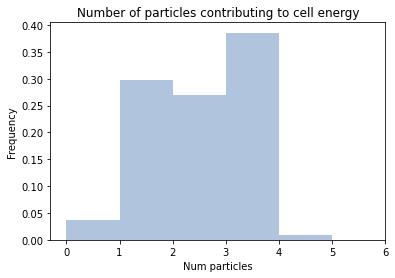

In [ ]:
# number of particles contributing to each cell
num_truth_contributions = np.array([[len(cell_truth_con) for clus_truth_con in event_truth_con for cell_truth_con in clus_truth_con] for event_truth_con in events_arr["cluster_cell_hitsTruthIndex"]])
pu.plot_hist(flatten_one_layer(num_truth_contributions), 6, "Number of particles contributing to cell energy", "Num particles", "Frequency", xlim=(None, 6), colour="lightsteelblue", discrete=True)

In [ ]:
# find events where all cells have no deposits???
# likely from noise cut out!!
no_cell_depoists = [np.count_nonzero(np.array(num_truth_contributions_event) == 0) == len(num_truth_contributions_event) for num_truth_contributions_event in num_truth_contributions]
print("num events with no cell deposits:", np.count_nonzero(no_cell_depoists))

num events with no cell deposits: 1


6


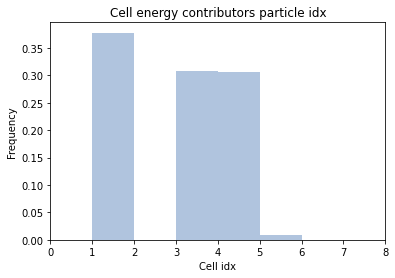

37.773% of energy contributions are from the charged pion and 62.227% are from the gammas


In [ ]:
# Of these particles which are depositing energy into the cells
# idx: 0-rho, 1-pi+/-, 2-pi0, 3-gamma, 4-gamma, 5-gamma
truth_part_name = { 0: "rho+/-", 1: "pi+/-", 2: "pi0", 3: "gamma1", 4: "gamma2", 5: "gamma3", 6: "gamma4" }
cell_energy_contr_part_idx = np.array(flatten_layers(events_arr["cluster_cell_hitsTruthIndex"], 3))
print(np.max(cell_energy_contr_part_idx))
pu.plot_hist(cell_energy_contr_part_idx, 6, "Cell energy contributors particle idx", "Cell idx", "Frequency", colour="lightsteelblue", xlim=(0,8), discrete=True) 
print(str(round((len(cell_energy_contr_part_idx[cell_energy_contr_part_idx == 1])/len(cell_energy_contr_part_idx))*100, 3)) + "% of energy contributions are from the charged pion and " + str(round((len(cell_energy_contr_part_idx[cell_energy_contr_part_idx != 1])/len(cell_energy_contr_part_idx))*100, 3)) + "% are from the gammas")


Mean number of clusters: 2.9979035639413
954


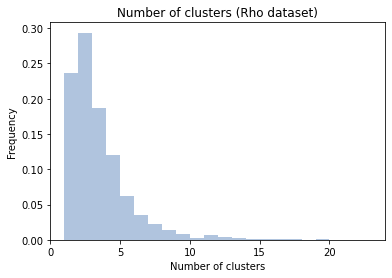

Mean number of tracks: 0.9454926624737946


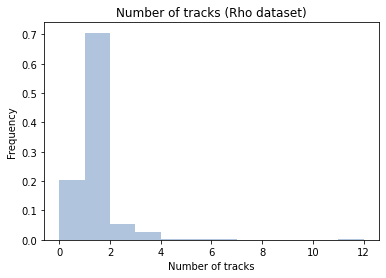

In [ ]:
print("Mean number of clusters:", np.mean(events_arr["nCluster"]))
print(len(events_arr["nCluster"]))
pu.plot_hist(np.array(events_arr["nCluster"]), 19, "Number of clusters (Rho dataset)", "Number of clusters", "Frequency", colour="lightsteelblue", discrete=True, xlim=(0, 24))

print("Mean number of tracks:", np.mean(events_arr["nTrack"]))
pu.plot_hist(np.array(events_arr["nTrack"]), 12, "Number of tracks (Rho dataset)", "Number of tracks", "Frequency", colour="lightsteelblue", discrete=True)

352136


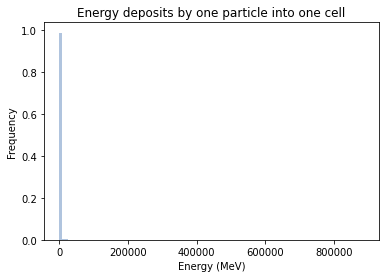

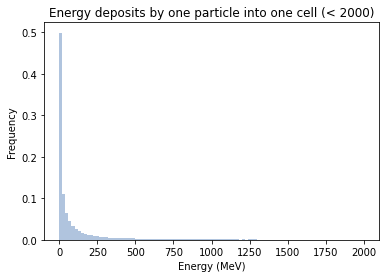

range: 0.0 -> 886749.5
energy deposits < 0: 0.0%
energy deposits < 2000: 95.63000000000001%
events with a neg energy deposit: 0.0%


In [ ]:
# how much energy are these single particles depositing into the cells
part_energy_deposits = np.array(flatten_layers(events_arr["cluster_cell_hitsTruthE"], 3))
print(len(part_energy_deposits))
pu.plot_hist(part_energy_deposits, 100, "Energy deposits by one particle into one cell", "Energy (MeV)", "Frequency", colour="lightsteelblue")
pu.plot_hist(part_energy_deposits[part_energy_deposits < 2000], 100, "Energy deposits by one particle into one cell (< 2000)", "Energy (MeV)", "Frequency", colour="lightsteelblue")
#pu.plot_hist(part_energy_deposits[part_energy_deposits < 0], 100, "Energy deposited by one particle into one cell (< 0)", "Energy (MeV)", "Frequency", colour="lightsteelblue")
print("range:", round(np.min(part_energy_deposits), 4), "->", np.max(part_energy_deposits))
print("energy deposits < 0:", str(round(len(part_energy_deposits[part_energy_deposits < 0])/len(part_energy_deposits), 5)*100) + "%")
print("energy deposits < 2000:", str(round(len(part_energy_deposits[part_energy_deposits < 2000])/len(part_energy_deposits), 5)*100) + "%")

# percent of events with a neg cell deposit
part_energy_deposits_events = np.array([np.count_nonzero([cell_part_deposit < 0 for cell_part_deposit in flatten_layers(event_part_deposits, 2)]) > 0 for event_part_deposits in events_arr["cluster_cell_hitsTruthE"]])
num_events = len(events_arr["cluster_cell_hitsTruthE"])
print("events with a neg energy deposit:", str(round(np.count_nonzero(part_energy_deposits_events) / num_events, 5)*100) + "%")

Lead particle energy deposit analysis

Find $\Delta$ R between charged and neutral pions

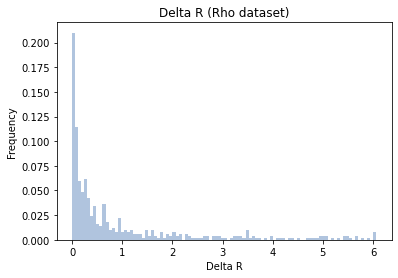

'\npipm_thetas = [2*np.arctan(np.exp(-eta)) for eta in pipm_etas]\npi0_thetas = [2*np.arctan(np.exp(-eta)) for eta in pi0_etas]\n\ndelta_R2 = np.cos(-1)*(np.cos(pipm_thetas)*np.cos(pi0_thetas) + np.sin(pipm_thetas)*np.sin(pi0_thetas)*np.cos(pipm_phis - pi0_phis))\npu.plot_hist(delta_R2, 100, "Delta R2 (Rho dataset)", "Delta R", "Frequency", colour="lightsteelblue")\n'

In [163]:
pipm_idx = 1
pi0_idx = 2

pipm_etas = np.array(events_arr['truthPartEta'][:, pipm_idx])
pipm_phis = np.array(events_arr['truthPartPhi'][:, pipm_idx])

pi0_etas = np.array(events_arr['truthPartEta'][:, pi0_idx])
pi0_phis = np.array(events_arr['truthPartPhi'][:, pi0_idx])

# angular separation between the vectors in the eta/phi plane - over events
delta_R = np.sqrt((pipm_etas - pi0_etas)**2 + (pipm_phis - pi0_phis)**2)

pu.plot_hist(delta_R, 100, "Delta R (Rho dataset)", "Delta R", "Frequency", colour="lightsteelblue")

"""
pipm_thetas = [2*np.arctan(np.exp(-eta)) for eta in pipm_etas]
pi0_thetas = [2*np.arctan(np.exp(-eta)) for eta in pi0_etas]

delta_R2 = np.cos(-1)*(np.cos(pipm_thetas)*np.cos(pi0_thetas) + np.sin(pipm_thetas)*np.sin(pi0_thetas)*np.cos(pipm_phis - pi0_phis))
pu.plot_hist(delta_R2, 100, "Delta R2 (Rho dataset)", "Delta R", "Frequency", colour="lightsteelblue")
"""

In [160]:
# get cell fracs
lead_contribution_frac = np.array([[np.max(cells_energy_contr)/np.sum(cells_energy_contr) if len(cells_energy_contr) else 0 for clus_energy_contr in event_energy_contr for cells_energy_contr in clus_energy_contr] for event_energy_contr in events_arr["cluster_cell_hitsTruthE"]])
frac_pipm_energy = np.array([[(cells_energy_contr[np.array(events_arr["cluster_cell_hitsTruthIndex"][event_idx][clus_idx][cell_idx]) == 1][0]/np.sum(cells_energy_contr)) if np.count_nonzero(events_arr["cluster_cell_hitsTruthIndex"][event_idx][clus_idx][cell_idx] == 1) else 0 for clus_idx, clus_energy_contr in enumerate(event_energy_contr) for cell_idx, cells_energy_contr in enumerate(clus_energy_contr)] for event_idx, event_energy_contr in enumerate(events_arr["cluster_cell_hitsTruthE"])])
empty_contr_frac = np.array([[False if len(cells_energy_contr) else True for clus_energy_contr in event_energy_contr for cells_energy_contr in clus_energy_contr] for event_energy_contr in events_arr["cluster_cell_hitsTruthE"]])


/tmp/ipykernel_12600/845361517.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lead_contribution_frac = np.array([[np.max(cells_energy_contr)/np.sum(cells_energy_contr) if len(cells_energy_contr) else 0 for clus_energy_contr in event_energy_contr for cells_energy_contr in clus_energy_contr] for event_energy_contr in events_arr["cluster_cell_hitsTruthE"]])
/tmp/ipykernel_12600/845361517.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frac_pipm_energy = np.array([[(cells_energy_contr[np.array(events_arr["cluster_cell_hitsTruthIndex"][event_idx]

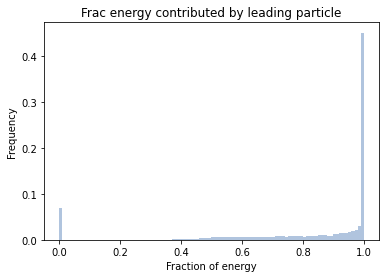

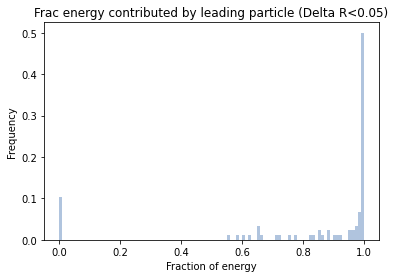

In [ ]:
delta_R_cut = 0.05
flat_lead_contr_frac = ak.Array(flatten_layers(lead_contribution_frac, 1))

pu.plot_hist(np.array(flat_lead_contr_frac), 100, "Frac energy contributed by leading particle", "Fraction of energy", "Frequency", colour="lightsteelblue")
pu.plot_hist(np.array(flat_lead_contr_frac[delta_R < delta_R_cut]), 100, "Frac energy contributed by leading particle (Delta R<" + str(delta_R_cut) +")", "Fraction of energy", "Frequency", colour="lightsteelblue")


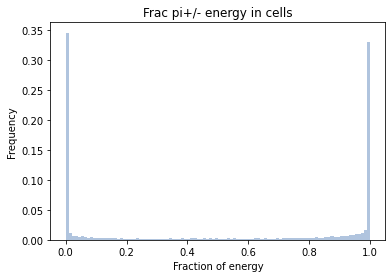

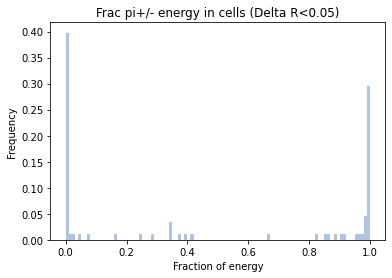

In [ ]:
flat_frac_pipm_energy = ak.Array(flatten_layers(frac_pipm_energy, 1))

pu.plot_hist(np.array(flat_frac_pipm_energy), 100, "Frac pi+/- energy in cells", "Fraction of energy", "Frequency", colour="lightsteelblue")
pu.plot_hist(np.array(flat_frac_pipm_energy[delta_R < delta_R_cut]), 100, "Frac pi+/- energy in cells (Delta R<" + str(delta_R_cut) +")", "Fraction of energy", "Frequency", colour="lightsteelblue")

Delta R: 3.4598095
pi+/- eta: [0.32, 0.495, 0.254, 0.261, 0.234] phi: [1.51, 1.93, 1.39, 1.38, 1.43]
calc deltaR: 0.5953139305996334
truth part ID: [213, 211, 111, 22, 22]
truth part E: [7.01, 1.75, 5.26, 3.94, 1.32]
cell EM: [[0.177, 0.00138, 0.085, 0.09, 0, 0.00147, 0.011, ... 0, 0, 0.000718, 0, 0.00401, 0]]
cell non EM: [[0.00103, 0, 0.00183, 0.00255, 0.000117, 0, ... 0, 1.53e-05, 0, 0.000276, 0.0058]]
truth part cell deposits Idx: [<Array [[3, 4], [3], [3, ... [3, 4], [4, 3]] type='34 * var * int64'>, <Array [[3], [3], [3], ... 3], [3], [3], []] type='22 * var * int64'>, <Array [[4, 3], [4, 3], [4, ... [3], [3], [3]] type='12 * var * int64'>, <Array [[1], [1], [1], ... 1], [], [1], [1]] type='22 * var * int64'>]
truth part cell deposits E: [<Array [[0.0579, 178], ... [3.45, 11.6]] type='34 * var * float64'>, <Array [[69.1], [19.9], ... [43.4], []] type='22 * var * float64'>, <Array [[1.67, 393], [12.8, ... [29.4], [30.6]] type='12 * var * float64'>, <Array [[179], [201], ... [4.28]

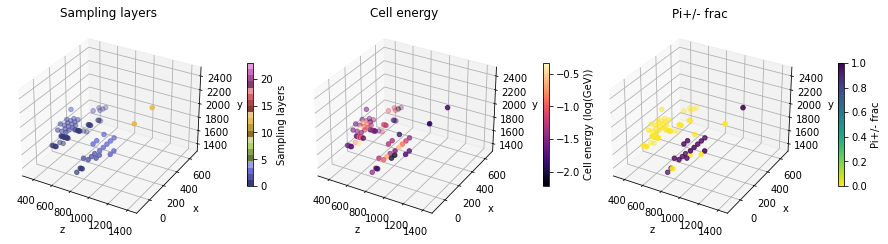

Delta R: 0.8621752
pi+/- eta: [1.31, 1.28, 1.79, 0.474, 1.79, 1.25] phi: [0.308, 0.325, 0.013, -2.37, 0.017, 0.324]
calc deltaR: 0.5968518895738466
truth part ID: [-213, -211, 111, 22, 22, 22]
truth part E: [28.2, 16.6, 2.36, 0.00488, 2.35, 9.18]
cell EM: [[2.62, 0.708, 0.395, 0.286, 0.164, 0.412, ... 0.00146, 0, 0.000305, 0.000875, 0]]
cell non EM: [[0.0353, 0.0971, 0.0356, 0.0923, 0.00863, ... 0.000192, 3.33e-05, 0, 1.21e-05, 0]]
truth part cell deposits Idx: [<Array [[1, 5], [1, 5], ... [5, 1], [5, 1]] type='50 * var * int64'>, <Array [[5, 1], [5, 1], [5, ... [1], [1], [1]] type='43 * var * int64'>, <Array [[4], [], [4], [4, ... 4], [4], [4], []] type='25 * var * int64'>, <Array [[5, 1], [5, 1], ... [5, 1], [5, 1]] type='22 * var * int64'>, <Array [[5, 1], [1], [1], ... [5, 1], [1], [1]] type='18 * var * int64'>, <Array [[5, 1], [1], [5, ... [1], [1, 5], []] type='10 * var * int64'>]
truth part cell deposits E: [<Array [[33.9, 2.62e+03], ... [0.994, 41.1]] type='50 * var * float64'>

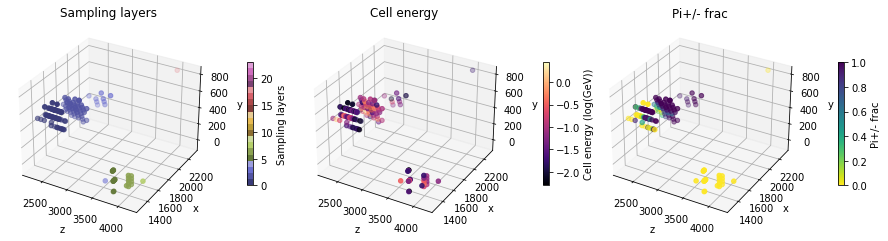

Delta R: 0.22066684
pi+/- eta: [2.54, 2.57, 2.51, 2.51, 2.51] phi: [0.898, 0.95, 0.835, 0.816, 0.837]
calc deltaR: 0.13067988230342328
truth part ID: [213, 211, 111, 22, 22]
truth part E: [280, 156, 123, 13, 110]
cell EM: [... 0.0427, 0.448, 0.123, 0.081, 0.0479, 0.0222, 0.599, 0, 0.0268, 0.00985]]
cell non EM: [... 0.33, 0.13, 0.19, 0.292, 1.86, 0.508, 0.225, 0.147, 0.421, 0, 0.245, 0.0374]]
truth part cell deposits Idx: [<Array [[1, 3, 4], [1, 3, 4, ... [1], [1], [1]] type='79 * var * int64'>]
truth part cell deposits E: [<Array [[220, 3.53e+03, 5.26e+04, ... [57.6]] type='79 * var * float64'>]
event index: 2
num cells: 79


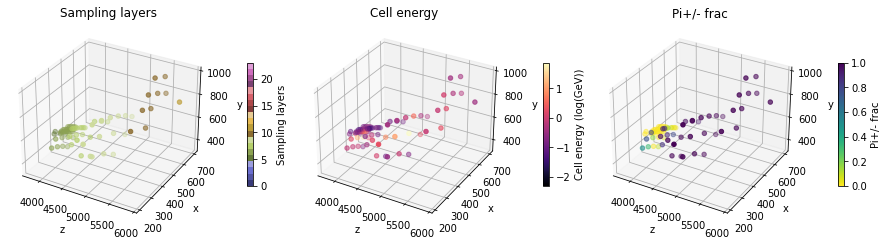

Delta R: 0.07352401
pi+/- eta: [0.761, 2.09, 0.512, 0.518, 0.48] phi: [1.14, 0.599, 1.19, 1.19, 1.14]
calc deltaR: 1.6877539173645402
truth part ID: [-213, -211, 111, 22, 22]
truth part E: [8.2, 2.05, 6.15, 5.24, 0.91]
cell EM: [[0.909, 0.0495, 0.624, 0.174, 0.0981, ... 0.00266, 0.0395, 0, 0.000735, 0.00749]]
cell non EM: [[0.0129, 0.000872, 0.0102, 0.0051, 0.00235, ... 0, 0.000277, 0, 0, 0.00056]]
truth part cell deposits Idx: [<Array [[4, 3], [4, 3], ... [3], [], [3]] type='34 * var * int64'>, <Array [[3, 4], [4], [3, ... [4, 3], [3, 4]] type='20 * var * int64'>]
truth part cell deposits E: [<Array [[0.0754, 921], [0.816, ... [], [28]] type='34 * var * float64'>, <Array [[0.146, 130], ... [1.07, 6.98]] type='20 * var * float64'>]
event index: 3
num cells: 54


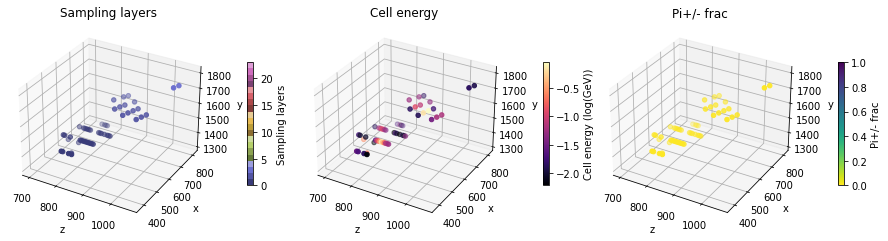

Delta R: 0.04648344
pi+/- eta: [-1.15, -1.21, -1.04, -1.05, -1.03, -1.19] phi: [1.76, 1.68, 1.9, 1.9, 1.9, 2.42]
calc deltaR: 0.2794758522725424
truth part ID: [-213, -211, 111, 22, 22, 22]
truth part E: [62.4, 40.8, 21.5, 11.7, 9.82, 0.00646]
cell EM: [[7.99, 0.0601, 0.0873, 0.165, 0.0401, 0.00238, ... 0.0366, 0.0303, 0, 0, 0.0752, 0]]
cell non EM: [[4.77, 0.0871, 0.0146, 0.0478, 0.174, 0.00198, ... 0.000461, 0, 0, 0.00127, 0]]
truth part cell deposits Idx: [<Array [[1], [1], [1], ... [1], [], [1], []] type='40 * var * int64'>, <Array [[3, 4], [3, 4], ... [1, 4, 3], []] type='111 * var * int64'>]
truth part cell deposits E: [<Array [[1.42e+04], [237], ... [34.2], []] type='40 * var * float64'>, <Array [[18.2, 1.04e+03], ... 75.6], []] type='111 * var * float64'>]
event index: 4
num cells: 151


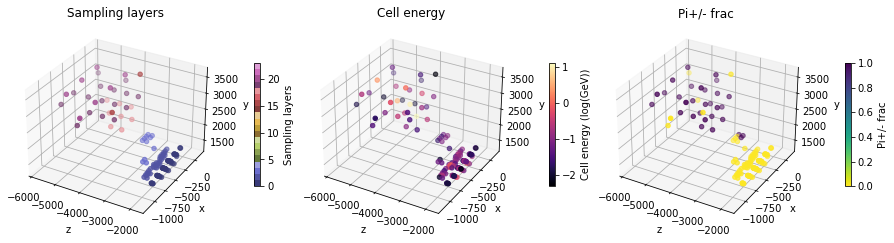

In [ ]:
# visualize cell deposit frac from pi+/-
event_idxs = np.arange(5)

for event_idx in event_idxs:
    print("Delta R:", delta_R[event_idx])
    print("pi+/- eta:", events_arr["truthPartEta"][event_idx], "phi:", events_arr["truthPartPhi"][event_idx])
    print("calc deltaR:", np.sqrt((events_arr["truthPartEta"][event_idx][1] - events_arr["truthPartEta"][event_idx][2])**2 + (events_arr["truthPartPhi"][event_idx][1] - events_arr["truthPartPhi"][event_idx][2])**2))
    print("truth part ID:", events_arr["truthPartPdgId"][event_idx])
    print("truth part E:", events_arr["truthPartE"][event_idx])
    print("cell EM:", events_arr["cluster_cell_hitsE_EM"][event_idx])
    print("cell non EM:", events_arr["cluster_cell_hitsE_nonEM"][event_idx])
    print("truth part cell deposits Idx:", events_arr["cluster_cell_hitsTruthIndex"][event_idx])
    print("truth part cell deposits E:", events_arr["cluster_cell_hitsTruthE"][event_idx])

    plot_event_3d_info(event_idx, frac_pipm_energy[event_idx], empty_contr_frac[event_idx])


frac events full pi+/- deposits: 0.0


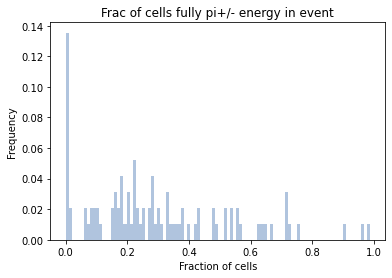

frac events full pi0 deposits: 0.10416666666666667


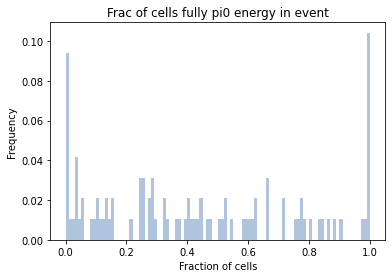

In [ ]:
# in the events what % have deposits from both types of pions
# (plot frac cells fully pi+/- and then plot frac cells fully pi0)
frac_cells_fully_pipm_in_event = np.array([np.count_nonzero(np.array(frac_pipm_energy_event) == 1)/len(frac_pipm_energy_event) for frac_pipm_energy_event in frac_pipm_energy])
frac_cells_fully_pi0_in_event = np.array([np.count_nonzero(np.array(frac_pipm_energy_event) == 0)/len(frac_pipm_energy_event) for frac_pipm_energy_event in frac_pipm_energy])

print("frac events full pi+/- deposits:", np.count_nonzero(np.array(frac_cells_fully_pipm_in_event) == 1)/len(frac_cells_fully_pipm_in_event))
pu.plot_hist(frac_cells_fully_pipm_in_event, 100, "Frac of cells fully pi+/- energy in event", "Fraction of cells", "Frequency", colour="lightsteelblue")

print("frac events full pi0 deposits:", np.count_nonzero(np.array(frac_cells_fully_pi0_in_event) == 1)/len(frac_cells_fully_pi0_in_event))
pu.plot_hist(frac_cells_fully_pi0_in_event, 100, "Frac of cells fully pi0 energy in event", "Fraction of cells", "Frequency", colour="lightsteelblue")


frac events with only pi+/- majority deposits: 0.010416666666666666
frac events with only pi0 majority deposits: 0.13541666666666666


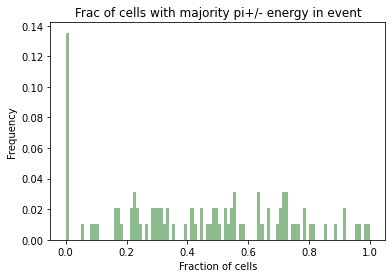

In [ ]:
# in the events what frac of cells have the majority of their energy from pi+/-

frac_cells_majority_pipm_in_event = np.array([np.count_nonzero(np.array(frac_pipm_energy_event) >= 0.5)/len(frac_pipm_energy_event) for frac_pipm_energy_event in frac_pipm_energy])
print("frac events with only pi+/- majority deposits:", np.count_nonzero(np.array(frac_cells_majority_pipm_in_event) == 1)/len(frac_cells_majority_pipm_in_event))
print("frac events with only pi0 majority deposits:", np.count_nonzero(np.array(frac_cells_majority_pipm_in_event) == 0)/len(frac_cells_majority_pipm_in_event))

pu.plot_hist(frac_cells_majority_pipm_in_event, 100, "Frac of cells with majority pi+/- energy in event", "Fraction of cells", "Frequency", colour="darkseagreen")


In [ ]:
# get event idxs where all cells are pi+/- or pi0
event_idx = np.arange(len(events_arr["cluster_cell_hitsTruthE"]))

events_with_all_pi0_deposits = event_idx[frac_cells_fully_pi0_in_event == 1]
events_with_all_pipm_deposits = event_idx[frac_cells_fully_pipm_in_event == 1]

In [273]:
# visualize cell deposit frac from pi+/- ^^
for event_idx in [0]:#events_with_all_pi0_deposits[:10]:
    #rint(frac_pipm_energy[event_idx][np.array(empty_contr_frac[event_idx])])
    print(len(frac_pipm_energy[event_idx]))
    print(len(np.array(empty_contr_frac[event_idx])))

    print("Delta R:", delta_R[event_idx])
    print("pi+/- eta:", events_arr["truthPartEta"][event_idx], "phi:", events_arr["truthPartPhi"][event_idx])
    print("calc deltaR:", np.sqrt((events_arr["truthPartEta"][event_idx][1] - events_arr["truthPartEta"][event_idx][2])**2 + (events_arr["truthPartPhi"][event_idx][1] - events_arr["truthPartPhi"][event_idx][2])**2))
    print("truth part ID:", events_arr["truthPartPdgId"][event_idx])
    print("truth part E:", events_arr["truthPartE"][event_idx])
    print("num pi+/- frac == 1:", np.count_nonzero(ak.Array(events_arr["cluster_cell_hitsTruthIndex"][event_idx]) == 1))
    print("num pi+/- frac != 1:", np.count_nonzero(ak.Array(events_arr["cluster_cell_hitsTruthIndex"][event_idx]) != 1))
    print("summed E from pi+/-:", np.sum(ak.Array(events_arr["cluster_cell_hitsTruthE"][event_idx])[ak.Array(events_arr["cluster_cell_hitsTruthIndex"][event_idx]) == 1], axis=None)/1000)
    print("summed E from pi0:", np.sum(ak.Array(events_arr["cluster_cell_hitsTruthE"][event_idx])[ak.Array(events_arr["cluster_cell_hitsTruthIndex"][event_idx]) != 1], axis=None)/1000)
    print("cell EM:", events_arr["cluster_cell_hitsE_EM"][event_idx])
    print("cell non EM:", events_arr["cluster_cell_hitsE_nonEM"][event_idx])
    print("cell escaped:", events_arr["cluster_cell_hitsE_Escaped"][event_idx])
    print("cell invisible:", events_arr["cluster_cell_hitsE_Invisible"][event_idx])
    print("summed over types of E:", np.sum(events_arr["cluster_cell_hitsE_EM"][event_idx] + events_arr["cluster_cell_hitsE_nonEM"][event_idx] + events_arr["cluster_cell_hitsE_Escaped"][event_idx] + events_arr["cluster_cell_hitsE_Invisible"][event_idx], axis=None))
    print("truth part cell deposits Idx:", events_arr["cluster_cell_hitsTruthIndex"][event_idx][0])
    print("truth part cell deposits E:", events_arr["cluster_cell_hitsTruthE"][event_idx][0])


    plot_event_3d_info(event_idx, np.array(frac_pipm_energy[event_idx]), np.array(empty_contr_frac[event_idx]))


16
16
Delta R: 3.4598095
pi+/- eta: [0.32, 0.495, 0.254, 0.261, 0.234] phi: [1.51, 1.93, 1.39, 1.38, 1.43]
calc deltaR: 0.5953139305996334
truth part ID: [213, 211, 111, 22, 22]
truth part E: [7.01, 1.75, 5.26, 3.94, 1.32]
num pi+/- frac == 1: 22
num pi+/- frac != 1: 109
summed E from pi+/-: 0.8614951782226562
summed E from pi0: 3.7630938968658447
cell EM: [[0.177, 0.00138, 0.000836, 0.085, 0.09, 0, 0.00495, ... 0, 0, 0, 0, 0, 0, 0.00117]]
cell non EM: [[0.00103, 0, 0.000159, 0.00183, 0.00255, 0.000117, ... 0, 0, 0, 0, 0.0058, 0.00578]]
cell escaped: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
cell invisible: [[2.96e-17, -1.25e-19, 9.02e-20, -9.97e-18, -2.71e-17, ... 0, 0, 5.02e-16, 1.59e-16]]
summed over types of E: 4.624589090029996
truth part cell deposits Idx: [[3, 4], [3], [3], [3, 4], [3, 4], [3], ... [4, 3], [3, 4], [4], [], [4, 3], [3]]
truth part cell deposits E: [[0.0579, 178], [1.38], [0.995], [0.495, 86.3, ... [0.917], [], [3.45, 11.

IndexError: boolean index did not match indexed array along dimension 0; dimension is 135 but corresponding boolean dimension is 16

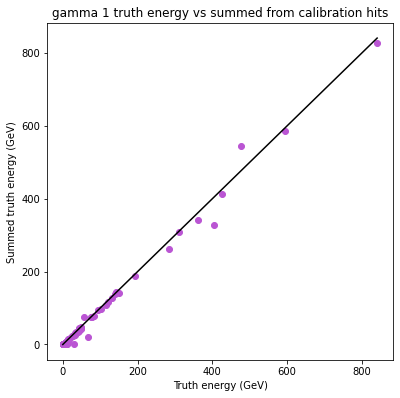

frac where full truth energy < summed: 3
frac where full truth energy < summed: 0.03


In [282]:
# check the alignment between summed energy and truth energy
part_idx = 3

pipm_particles_truth_energy = np.array(ak.Array(events_arr["truthPartE"])[:,part_idx])
pipm_summed_particles_deposited_energy = np.array([np.sum([np.sum(cell_truth_E_filter_part) for clus_cell_truth_E_filter_part in event_clus_cell_truth_E_filter_part for cell_truth_E_filter_part in clus_cell_truth_E_filter_part]) for event_clus_cell_truth_E_filter_part in ak.Array(events_arr["cluster_cell_hitsTruthE"])[ak.Array(events_arr["cluster_cell_hitsTruthIndex"]) == part_idx]])/1000


fig = plt.figure(figsize=(6.2,6.2))
fig.patch.set_facecolor('white')
plt.scatter(pipm_particles_truth_energy, pipm_summed_particles_deposited_energy, color="mediumorchid")
plt.title("gamma 1 truth energy vs summed from calibration hits")
plt.xlabel("Truth energy (GeV)")
plt.ylabel("Summed truth energy (GeV)")
plt.plot(np.arange(np.max(pipm_particles_truth_energy)), np.arange(np.max(pipm_particles_truth_energy)), color="black")
#plt.xlim((-1, 25)) 
#plt.ylim((-1, 25))
plt.show()


print("frac where full truth energy < summed:", np.count_nonzero(pipm_particles_truth_energy < pipm_summed_particles_deposited_energy))
print("frac where full truth energy < summed:", np.count_nonzero(pipm_particles_truth_energy < pipm_summed_particles_deposited_energy)/len(pipm_summed_particles_deposited_energy))


In [275]:
#rho_root_data = ur.open("~/start_tf/rho_full_500.root")
#rho_root_data = ur.open("/data/atlas/data/allCellTruthv1/pipm/user.mswiatlo.27153452.OutputStream._000001.root")
rho_root_data = ur.open("/fast_scratch_1/jbohm/train_testing_data/mltree_100_compare_no_cut.root")
rho_root_data_truth_sum = ur.open("/fast_scratch_1/jbohm/train_testing_data/mltree_100_compare_no_cut_truth_sum.root")

#rho_root_data_summed_truth_E = ur.open("~/start_tf/rho_full_500.root")

events = rho_root_data["EventTree"]
events_truth_sum = rho_root_data_truth_sum["EventTree"]
events_arr = events.arrays(library="ak")
events_arr_truth_sum = events_truth_sum.arrays(library="ak")

#events_arr_truth_E = rho_root_data_summed_truth_E["EventTree"]
#events_arr_summed_truth_E = events_summed_truth_E.arrays(library="ak")

In [287]:
def plot_truth_E_comparison(truth_E_1, truth_E_2, title, xlabel, ylabel):
    fig = plt.figure(figsize=(6.2,6.2))
    fig.patch.set_facecolor('white')
    plt.scatter(truth_E_1, truth_E_2, color="mediumorchid")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.arange(np.max(truth_E_1)), np.arange(np.max(truth_E_1)), color="black")
    plt.show()

    print("count where truth_E_1 < truth_E_2:", np.count_nonzero(truth_E_1 < truth_E_2))
    print("frac where truth_E_1 < truth_E_2:", np.count_nonzero(truth_E_1 < truth_E_2)/len(truth_E_1))



Compare summed in c++ and summed here in analysis

In [291]:
# regular truth part values in tree
rho_root_data_compare = ur.open("/fast_scratch_1/jbohm/train_testing_data/mltree_100_compare_no_cut.root")
events_compare = rho_root_data_compare["EventTree"]
events_arr_compare = events_compare.arrays(library="ak")

# save summed calo hits as truth part values in tree
rho_root_data_truth_sum = ur.open("/fast_scratch_1/jbohm/train_testing_data/mltree_100_compare_no_cut_truth_sum.root")
events_truth_sum = rho_root_data_truth_sum["EventTree"]
events_arr_truth_sum = events_truth_sum.arrays(library="ak")

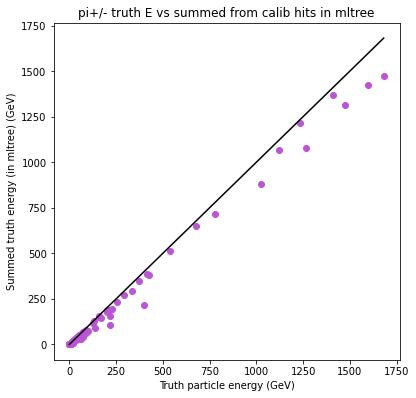

count where truth_E_1 < truth_E_2: 0
frac where truth_E_1 < truth_E_2: 0.0


In [292]:
# set part_idx to select truth sums for a certain particle
part_idx_to_name = {
    1: "pi+/-", 
    3: "gamma1",
    4: "gamma2",
}
part_idx = 1
truth_part_E = events_compare["truthPartE"].array()[:, part_idx]
truth_part_E_summed_cpp = events_truth_sum["truthPartE"].array()[:100, part_idx]

# plot truth E comparison
plot_truth_E_comparison(truth_part_E, truth_part_E_summed_cpp, part_idx_to_name[part_idx] + " truth E vs summed from calib hits in mltree","Truth particle energy (GeV)", "Summed truth energy (in mltree) (GeV)")


Compare truth E to summed energies for rho particle

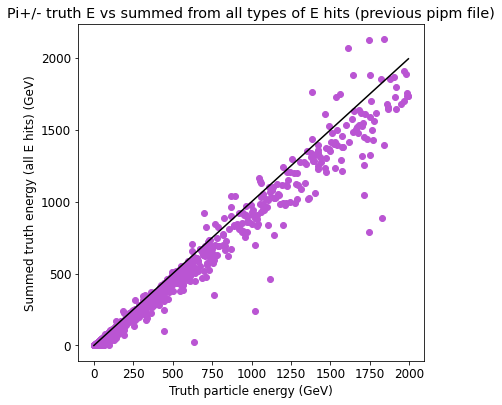

count where truth_E_1 < truth_E_2: 49
frac where truth_E_1 < truth_E_2: 0.0245


In [382]:
# load previous pi+/- file
rho_root_data_prev_pipm = ur.open("/data/atlas/data/allCellTruthv1/pipm/user.mswiatlo.27153452.OutputStream._000001.root")
events_prev_pipm = rho_root_data_prev_pipm["EventTree"]
events_arr_prev_pipm = events_prev_pipm.arrays(library="ak")

# get the truth part value for the part of idx 1: pipm
truth_part_E_pipm = events_prev_pipm["truthPartE"].array()[:,0]

# sum E hits EM, non EM, escaped, and invisible - keep same shape
list_truth_part_E = events_arr_prev_pipm["cluster_cell_hitsE_EM"] + events_arr_prev_pipm["cluster_cell_hitsE_nonEM"] + events_arr_prev_pipm["cluster_cell_hitsE_Escaped"] + events_arr_prev_pipm["cluster_cell_hitsE_Invisible"]

# sum all hits over event to get summed truth E from different energies 
summed_truth_part_E_pipm = [np.sum([cell_truth_part_E for clus_truth_part_E in event_truth_part_E for cell_truth_part_E in clus_truth_part_E]) for event_truth_part_E in list_truth_part_E]

plot_truth_E_comparison(truth_part_E_pipm, summed_truth_part_E_pipm, "Pi+/- truth E vs summed from all types of E hits (previous pipm file)","Truth particle energy (GeV)", "Summed truth energy (all E hits) (GeV)")


Q - was the alignment issue the repeated cells in an event? <br>
CHECK - filter out the repeated cells, sum, and see if it is the same as the summed in mltree

In [397]:
# flatten cell IDs and summed E over types of E
events_cells_IDs = [[cell for clus in event for cell in clus] for event in events_arr["cluster_cell_ID"]]

summed_truth_part_E_pipm_truth_part_E = events_arr["cluster_cell_hitsE_EM"] + events_arr["cluster_cell_hitsE_nonEM"] + events_arr["cluster_cell_hitsE_Escaped"] + events_arr["cluster_cell_hitsE_Invisible"]


events_summed_truth_part_E = [[cell for clus in event for cell in clus] for event in summed_truth_part_E_pipm_truth_part_E]

unique_summed_truth_part_E = []

# iterate through the events and remove any repeated cell deposits (if 2+ of same cell ID in one event remove the extra)
for event_idx in np.arange(len(events_cells_IDs)):
    if len(events_cells_IDs[event_idx]):
        # get the idx of the unique cell IDs
        unique_events_cells_IDs, unique_cells_idx = np.unique(events_cells_IDs[event_idx], return_index=True)

        # cut the particle ID and energy depoists to just have the unique cells per event
        unique_summed_truth_part_E.append(ak.Array(events_summed_truth_part_E[event_idx])[unique_cells_idx])

    else:
        unique_summed_truth_part_E.append([])

In [398]:
print(np.sum(unique_summed_truth_part_E[0]))
print(len(unique_summed_truth_part_E))

4.624589090029996
100


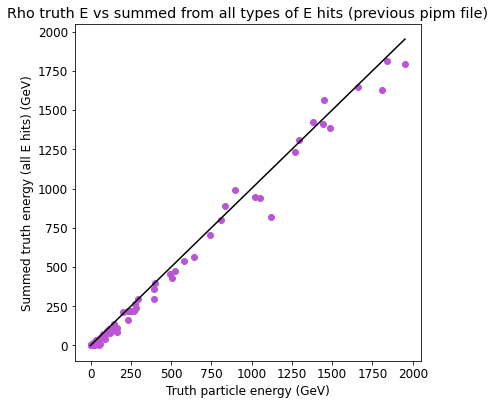

count where truth_E_1 < truth_E_2: 8
frac where truth_E_1 < truth_E_2: 0.08


In [400]:

# get the truth part value for the part of idx 1: pipm
truth_part_E_pipm = events["truthPartE"].array()[:,0]

# sum E hits EM, non EM, escaped, and invisible - keep same shape
list_truth_part_E = events_arr["cluster_cell_hitsE_EM"] + events_arr["cluster_cell_hitsE_nonEM"] + events_arr["cluster_cell_hitsE_Escaped"] + events_arr["cluster_cell_hitsE_Invisible"]

# sum all hits over event to get summed truth E from different energies 
summed_truth_part_E_pipm = [np.sum([cell_truth_part_E for clus_truth_part_E in event_truth_part_E for cell_truth_part_E in clus_truth_part_E]) for event_truth_part_E in list_truth_part_E]

plot_truth_E_comparison(truth_part_E_pipm, summed_truth_part_E_pipm, "Rho truth E vs summed from all types of E hits (previous pipm file)","Truth particle energy (GeV)", "Summed truth energy (all E hits) (GeV)")


100
100


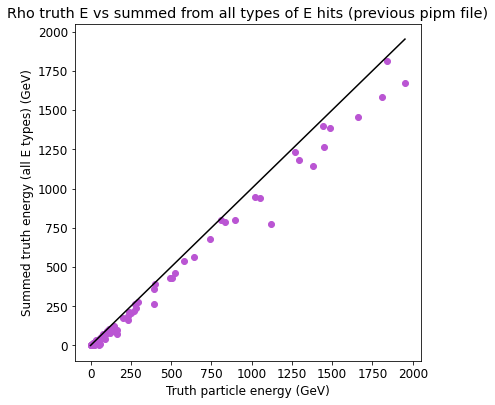

count where truth_E_1 < truth_E_2: 0
frac where truth_E_1 < truth_E_2: 0.0


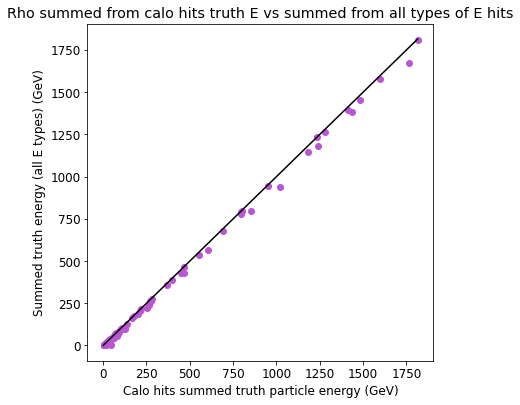

count where truth_E_1 < truth_E_2: 0
frac where truth_E_1 < truth_E_2: 0.0


In [410]:
# get the truth part value for the part of idx 1: pipm
truth_part_E = events["truthPartE"].array()[:,0]

# sum all hits over event to get summed truth E from different energies 
unique_summed_truth_part_E = [np.sum(event_truth_part_E) for event_truth_part_E in unique_summed_truth_part_E]

print(len(truth_part_E))
print(len(unique_summed_truth_part_E))

plot_truth_E_comparison(truth_part_E, unique_summed_truth_part_E, "Rho truth E vs summed from all types of E hits (previous pipm file)","Truth particle energy (GeV)", "Summed truth energy (all E types) (GeV)")

# also compare unique summed truth part E to summed truth part E from ml tree (before topo clustering??)

mltree_summed_truth_part_E = [np.sum(event_truth_part_E) for event_truth_part_E in events_truth_sum["truthPartE"].array()]
plot_truth_E_comparison(mltree_summed_truth_part_E, unique_summed_truth_part_E, "Rho summed from calo hits truth E vs summed from all types of E hits","Calo hits summed truth particle energy (GeV)", "Summed truth energy (all E types) (GeV)")


In [ ]:
tree = up.open()